## 程序说明

#### 目录下保存了训练过程中的损失变化与准确性变化(存为npy文件)，训练后的模型也被保存。若运行该文档时，检测到目录下有这些文件，就会调用display函数展示之前的训练过程，并加载模型测试在测试集上的精确度。删去这些文件可以重新训练模型。

#### 如果没有删除文件，直接点击运行相当于展示之前的训练过程，并加载模型测试在测试集上的精确度，但训练过程中的部分print和图像就没了，建议在运行前先阅读程序并看之前展示的图像和数据，阅读完毕后再点击运行，检查模型的效果。

# ATTENTION!
## 我训练程序的环境是Linux + CUDA 10，助教检查的过程中可能会出现报错的情况，这可能是由于CUDA 引起的，若有报错烦请助教联系我(张弛)，带来的不便非常抱歉!

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import os


In [2]:
#  creating neural network
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet,self).__init__()
        # input torch.Size([4, 1, 28, 28])
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d((12,12))
        )  # torch.Size([4, 64, 12, 12])
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d((10,10))
        )  # torch.Size([4, 32, 4, 4])
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )  # torch.Size([4, 16, 6, 6])
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d((5,5))
        )  # torch.Size([4, 10, 5, 5])

        self.fc1 = nn.Sequential(
            nn.Linear(1600,800),
            nn.ReLU(inplace=True),
            nn.Linear(800,10)
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        #print(x.size())
        x = self.conv2(x)
        #print(x.size())
        x = self.conv3(x)
        #print(x.size())
        x = self.conv4(x)
        #print(x.size())
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return x

In [3]:
def set_seed(seed=20):
    np.random.seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
set_seed(20)
BATCH = 20
# train set
train_set = datasets.MNIST(root='./',train=True,transform=transforms.ToTensor(),download=True)
print('train:',len(train_set))
# test set
test_set = datasets.MNIST(root='./',train=False,transform=transforms.ToTensor(),download=True)
print('test',len(test_set))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=BATCH,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=BATCH,shuffle=True)


train: 60000
test 10000


In [5]:
# define the train function
def train(model, train_set, optimizer):
    model.train() 
    losses = 0
    accurate_classification = 0
    for data, ground_truth in train_set:
        if torch.cuda.is_available():
            data = data.cuda()
            ground_truth = ground_truth.cuda()
        classification = model(data.float()) # a tensor which represents the probability of each category
        
        for i_batch in range(classification.size()[0]):
            if int(torch.max(classification[i_batch,:],0)[1].item()) == int(ground_truth[i_batch]):
                accurate_classification += 1
            
        loss_function = nn.CrossEntropyLoss()
        loss = loss_function(classification,ground_truth)
        losses  += loss
    # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return losses.item()/len(train_set)/classification.size()[0], accurate_classification/len(train_set)/classification.size()[0]
    # lenth of train_set multiply batch size is the num of the pics for training

def validation(model, val_set):
    model.eval()
    losses = 0
    accurate_classification = 0
    for data, ground_truth in val_set:
        if torch.cuda.is_available():
            data = data.cuda()
            ground_truth = ground_truth.cuda()
        classification = model(data.float()) # a tensor which represents the probability of each category
        
        for i_batch in range(classification.size()[0]):
            if int(torch.max(classification[i_batch,:],0)[1].item()) == int(ground_truth[i_batch]):
                accurate_classification += 1
            
        loss_function = nn.CrossEntropyLoss()
        loss = loss_function(classification,ground_truth)
        losses  += loss
    
    return losses.item()/len(val_set)/classification.size()[0], accurate_classification/len(val_set)/classification.size()[0]
    # lenth of train_set multiply batch size is the num of the pics for testing

In [6]:
def train_and_test():
    model = MNISTNet()
    if torch.cuda.is_available():
        model.cuda()
    parameters = model.parameters()
    optimizer = torch.optim.Adam(parameters, lr = 0.0001,
                                     betas=(0.9, 0.999),
                                     weight_decay=0)
    train_loss_epoch = []
    test_loss_epoch = []
    train_accuracy_epoch = []
    test_accuracy_epoch = []
    
    best_accuracy = 0
    
    for epoch in range(25):
        
        train_loss, train_accuracy = train(model,train_loader,optimizer)
        test_loss, test_accuracy = validation(model, test_loader)
        
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
        train_accuracy_epoch.append(train_accuracy)
        test_accuracy_epoch.append(test_accuracy)   
        print('test_accuracy',test_accuracy)
        
        if test_accuracy>best_accuracy:# save the best model
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), 'MNIST_model.pth.tar')
            
    np.save('train_loss_epoch.npy', np.array(train_loss_epoch))
    np.save('test_loss_epoch.npy', np.array(test_loss_epoch))
    np.save('train_accuracy_epoch.npy', np.array(train_accuracy_epoch))
    np.save('test_accuracy_epoch.npy', np.array(test_accuracy_epoch))
    
    return train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch
    

In [7]:
def visualization(train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch):
    print('Accuracy on train set',max(train_accuracy_epoch))
    print('Accuracy on validation set',max(test_accuracy_epoch))

    
    l1,=plt.plot(list(range(len(test_accuracy_epoch))),test_accuracy_epoch)
    l2,=plt.plot(list(range(len(train_accuracy_epoch))),train_accuracy_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Accuracy') 
    plt.xlabel('epoch')
    plt.title('Accuracy on Train Set and Validation Set') 
    plt.show()
    
    l1,=plt.plot(list(range(len(test_loss_epoch))),test_loss_epoch)
    l2,=plt.plot(list(range(len(train_loss_epoch))),train_loss_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Loss') 
    plt.xlabel('epoch')
    plt.title('Loss on Train Set and Validation Set') 
    plt.show()

In [8]:
def display():
    test_accuracy_epoch = np.load('test_accuracy_epoch.npy').tolist()
    test_loss_epoch = np.load('test_loss_epoch.npy').tolist()
    train_accuracy_epoch = np.load('train_accuracy_epoch.npy').tolist()
    train_loss_epoch = np.load('train_loss_epoch.npy').tolist()
    
    l1,=plt.plot(list(range(len(test_accuracy_epoch))),test_accuracy_epoch)
    l2,=plt.plot(list(range(len(train_accuracy_epoch))),train_accuracy_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Accuracy') 
    plt.xlabel('epoch')
    plt.title('Accuracy on Train Set and Validation Set') 
    plt.show()
    
    l1,=plt.plot(list(range(len(test_loss_epoch))),test_loss_epoch)
    l2,=plt.plot(list(range(len(train_loss_epoch))),train_loss_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Loss') 
    plt.xlabel('epoch')
    plt.title('Loss on Train Set and Validation Set') 
    plt.show()
    
    model =  MNISTNet()
    if torch.cuda.is_available():
        model.cuda()
    weights = torch.load('MNIST_model.pth.tar')
    model.load_state_dict(weights)
    _, test_accuracy = validation(model, test_loader)
    print('test_accuracy',test_accuracy)
    

test_accuracy 0.9632
test_accuracy 0.9792
test_accuracy 0.9839
test_accuracy 0.9865999999999999
test_accuracy 0.9871000000000001
test_accuracy 0.9911
test_accuracy 0.9856999999999999
test_accuracy 0.9914
test_accuracy 0.9906
test_accuracy 0.9917
test_accuracy 0.9906
test_accuracy 0.9904
test_accuracy 0.9929
test_accuracy 0.9887
test_accuracy 0.9906
test_accuracy 0.9901
test_accuracy 0.9921
test_accuracy 0.9906
test_accuracy 0.9898
test_accuracy 0.9909000000000001
test_accuracy 0.9894999999999999
test_accuracy 0.9912000000000001
test_accuracy 0.9922000000000001
test_accuracy 0.9902
test_accuracy 0.9917999999999999
Accuracy on train set 0.9987999999999999
Accuracy on validation set 0.9929


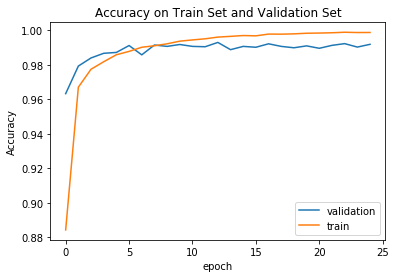

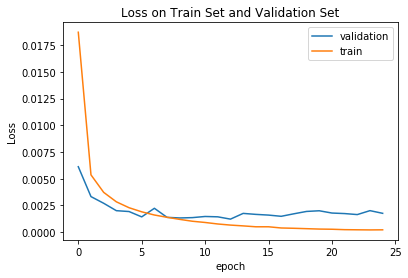

In [9]:
if not os.path.exists('MNIST_model.pth.tar'):
    train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch = train_and_test()
    visualization(train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch)

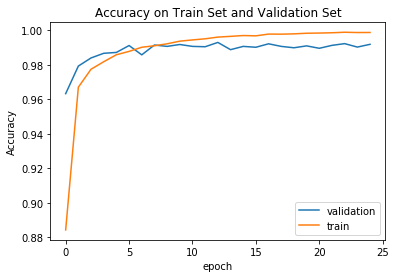

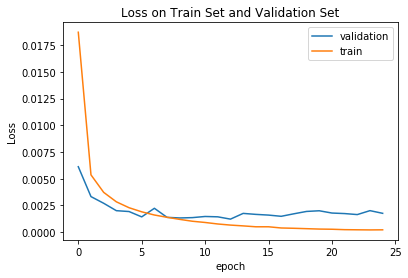

test_accuracy 0.9929


In [10]:
if os.path.exists('MNIST_model.pth.tar'):
    display()